In [54]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import caffe2
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe
import os
import cv2
import random
import lmdb

from caffe2.python import core, utils, workspace
from caffe2.proto import caffe2_pb2

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

seqSize = 7
subSeqSize = 500
totalNoisyImage = []
totalRefImage = []


Necessities imported!


In [55]:
def generateSequence(index,seqSize,noisyDatPath,refDatPath):
    noisySeq = []
    refSeq = []
    imgList = os.listdir(noisyDatPath)
    imgList.sort()
   
    if((index+seqSize)>len(imgList)):
        seqSize = len(imgList) - index
  
    for i in range(seqSize):
        noisyImg = cv2.imread(noisyDatPath+"//"+imgList[index+i])
        refImg   = cv2.imread(refDatPath+"//"+imgList[index+i])
        #noisyImg = cv2.imread(noisyDatPath+"//"+imgList[index+i])
        #refImg   = cv2.imread(refDatPath+"//"+imgList[index+i])
        noisySeq.append(noisyImg)
        refSeq.append(refImg)
    
        
    return noisySeq,refSeq
    
    

In [56]:
def generateSubseqence(srcNoisyImg,srcRefImg,seqSize,subSeqSize):
    
    noisySubSeq = []
    refSubSeq = []
    subSeqWindow = 128 #trying to create subimages of size 32x32, paper works with 128x128

    width,height = noisySeq[0].shape[0],noisySeq[0].shape[1]
    
    for k in range(subSeqSize):
        initW = random.randint(0,width-subSeqWindow-1)
        initH = random.randint(0,height-subSeqWindow-1)
        for i in range(seqSize):
            if(i>len(srcNoisyImg)-1):
                break
            subImageNoisy = srcNoisyImg[i][initW:initW+subSeqWindow,initH:initH+subSeqWindow,:3]
            subImageRef   = srcRefImg[i][initW:initW+subSeqWindow,initH:initH+subSeqWindow,:3]
            wN,hN = subImageRef.shape[0],subImageRef.shape[1]
            if((wN != subSeqWindow) or(hN != subSeqWindow)):
                print("width or height does not match:"+str(wN)+"x"+str(hN)+" initW:"+str(initW)+":"+str(initW+subSeqWindow)+" initH:"+str(initH)+":"+str(initH+subSeqWindow))
            noisySubSeq.append(subImageNoisy)
            refSubSeq.append(subImageRef)
        
    return noisySubSeq,refSubSeq
    

In [57]:
def showImage(img):
    pyplot.figure()
    pyplot.subplot(1,2,1)
    pyplot.imshow(img)
    pyplot.axis('on')
    pyplot.title('Original image = RGB')

In [58]:
def write_db(db_type, db_name, imgSeq, refSeq):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(len(imgSeq)):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(imgSeq[i]),
            utils.NumpyArrayToCaffe2Tensor(refSeq[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

In [59]:
noisyTraining = "//home//rohit//Rohit//Internship//caffe//projects//ML_TAA//data//trainingData//Noisy"
refTraining = "//home//rohit//Rohit//Internship//caffe//projects//ML_TAA//data//trainingData//Ref"

i = 0
if(len(os.listdir(noisyTraining)) !=  len(os.listdir(refTraining))):
    print("Error: Training and ref sizes match!")

dirSize = len(os.listdir(noisyTraining))
seqSize = 7
subSeqSize = 500
totalNoisyImage = []
totalRefImage = []

while(i < dirSize):
    noisySeq,refSeq = generateSequence(i,seqSize,noisyTraining,refTraining)
    noisySubSeq,refSubSeq = generateSubseqence(noisySeq,refSeq,seqSize,subSeqSize)
    totalNoisyImage.extend(noisySubSeq)
    totalRefImage.extend(refSubSeq)

    '''if i == 0:
        for k in range(len(noisySubSeq)):
            showImage(noisySubSeq[k])
            showImage(refSubSeq[k])'''
    i+=seqSize

write_db("minidb", "//home//rohit//Rohit//Internship//TAA_ML//ML_TAA.minidb", totalNoisyImage,totalRefImage)
seqSize = 1

In [60]:
seqSize = 1
def AddInput(model, batch_size, db, db_type):
    noisyImg_uint8,refImg_uint8 = model.TensorProtosDBInput([], ["noisyImg_uint8", "refImg_uint8"], batch_size=batch_size,
        db=db, db_type=db_type)
    
    noisyImg = model.Cast(noisyImg_uint8, "noisyImg", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    noisyImg = model.Scale(noisyImg, noisyImg, scale=float(1./256))
    noisyImg = model.NHWC2NCHW(noisyImg,"noisyImgNCHW")
    # don't need the gradient for the backward pass
    noisyImg = model.StopGradient(noisyImg, noisyImg)
    
    
    refImg = model.Cast(refImg_uint8, "refImg", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    refImg = model.Scale(refImg, refImg, scale=float(1./256))
    refImg = model.NHWC2NCHW(refImg,"refImgNCHW")
    # don't need the gradient for the backward pass
    refImg = model.StopGradient(refImg, refImg)
    
    #used for Temporal Loss
    
    prevImg =  model.param_init_net.ConstantFill([], 'prevImgNCHW', shape=[1,3,128,128]) # one RGB Image
    prevImg = model.StopGradient(prevImg,prevImg)
    
    prevGenImg =  model.param_init_net.ConstantFill([], 'prevDout', shape=[1,3,128,128]) # one RGB Image
    prevGenImg = model.StopGradient(prevGenImg,prevGenImg)
    
    return noisyImg, refImg
    

In [61]:
CONV_KERNEL_SIZE  = 3

CONV_KERNEL_PADING1 = 1
CONV_KERNEL_STRIDE1 = 1

CONV_KERNEL_PADING2 = 4
CONV_KERNEL_STRIDE2 = 3

def AddRecurrentBlock(model,data,layerNo,hiddenLayer,W,U,bias,filter_count_in,filter_count_out):
    #convR1 = brew.conv(model, data, 'conv1', dim_in=3, dim_out=20, kernel=3,pad_t=1,pad_l=4,pad_r=4,pad_b=1,stride = 1)
   
    convR1 = brew.conv(model,data,"convR1"+str(layerNo),dim_in=filter_count_in,dim_out=filter_count_out,
                       kernel=CONV_KERNEL_SIZE,stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    
    '''conCatR1,conCatDimsR1 = model.net.Concat( [convR1, hiddenLayer],['concatR1'+str(layerNo), 'conCatDimsR1'+str(layerNo)], axis=3)
    convR2 = brew.conv(model,conCatR1,"convR2"+str(layerNo),dim_in=filter_count_out,dim_out=filter_count_out,
                       kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    
    temp1 = model.net.BatchMatMul([hiddenLayer,W],"temp1"+str(layerNo))
    temp2 = model.net.BatchMatMul([convR1,U],"temp2"+str(layerNo))
    temp3 = model.net.Add([temp1,temp2],"temp3"+str(layerNo))
    convR2 = model.net.Tanh(temp3,"convR2"+str(layerNo))

    convR3 = brew.conv(model,convR2,"convR3"+str(layerNo),dim_in=filter_count_out,dim_out=filter_count_out,
                       kernel=CONV_KERNEL_SIZE,stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    hiddenLayer = convR3
    
    return convR3

In [62]:
def AddEncoderDecoder(model, noisyData):
    
    #creating recurrent hidden layers
    hidden1 = model.param_init_net.XavierFill([], 'hidden1', shape=[seqSize,8,128,128])
    weights1 = model.param_init_net.XavierFill([], 'weights1', shape=[seqSize,8,128,128])
    hweights1 = model.param_init_net.XavierFill([], 'hweights1', shape=[seqSize,8,128,128])
    bias1 = model.param_init_net.XavierFill([], 'bias1', shape=[seqSize,8,128,128])
    
    hidden2 = model.param_init_net.XavierFill([], 'hidden2', shape=[seqSize,16,64,64])
    weights2 = model.param_init_net.XavierFill([], 'weights2', shape=[seqSize,16,64,64])
    hweights2 = model.param_init_net.XavierFill([], 'hweights2', shape=[seqSize,16,64,64])
    bias2 = model.param_init_net.XavierFill([], 'bias2', shape=[seqSize,16,64,64])
    
    hidden3 = model.param_init_net.XavierFill([], 'hidden3', shape=[seqSize,32,32,32])
    weights3 = model.param_init_net.XavierFill([], 'weights3', shape=[seqSize,32,32,32])
    hweights3 = model.param_init_net.XavierFill([], 'hweights3', shape=[seqSize,32,32,32])
    bias3 = model.param_init_net.XavierFill([], 'bias3', shape=[seqSize,32,32,32])
    
    hidden4 = model.param_init_net.XavierFill([], 'hidden4', shape=[seqSize,64,16,16])
    weights4 = model.param_init_net.XavierFill([], 'weights4', shape=[seqSize,64,16,16])
    hweights4 = model.param_init_net.XavierFill([], 'hweights4', shape=[seqSize,64,16,16])
    bias4 = model.param_init_net.XavierFill([], 'bias4', shape=[seqSize,64,16,16])
    
    hidden5 = model.param_init_net.XavierFill([], 'hidden5', shape=[seqSize,128,8,8])
    weights5 = model.param_init_net.XavierFill([], 'weights5', shape=[seqSize,128,8,8])
    hweights5 = model.param_init_net.XavierFill([], 'hweights5', shape=[seqSize,128,8,8])
    bias5 = model.param_init_net.XavierFill([], 'bias5', shape=[seqSize,128,8,8])
    
    
    hidden6 = model.param_init_net.XavierFill([], 'hidden6', shape=[seqSize,256,4,4])
    weights6 = model.param_init_net.XavierFill([], 'weights6', shape=[seqSize,256,4,4])
    hweights6 = model.param_init_net.XavierFill([], 'hweights6', shape=[seqSize,256,4,4])
    bias6 = model.param_init_net.XavierFill([], 'bias6', shape=[seqSize,256,4,4])
    
    
    #ENCODER PART
    # Image size: 128 x 128 -> 128 x 128
    conv1 = AddRecurrentBlock(model,noisyData,1,hidden1,hweights1,weights1,bias1,3,8)
    # Image size: 64 x 64 -> 64 x 64
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel = 2, stride = 2)

    # Image size: 64 x 64 -> 64 x 64
    conv2 = AddRecurrentBlock(model,pool1,2,hidden2,hweights2,weights2,bias2,8,16)
    # Image size: 64x64 -> 32x32
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    
    # Image size: 32x32 -> 32 x 32
    conv3 = AddRecurrentBlock(model,pool2,3,hidden3,hweights3,weights3,bias3,16,32)
    # Image size: 32x32 -> 16x16
    pool3 = brew.max_pool(model, conv3, 'pool3', kernel=2, stride=2)
    
    # Image size: 16x16 -> 16x16
    conv4 = AddRecurrentBlock(model,pool3,4,hidden4,hweights4,weights4,bias4,32,64)
    # Image size: 16x16 -> 8x8 
    pool4 = brew.max_pool(model, conv4, 'pool4', kernel=2, stride=2)
    
    # Image size: 8x8 -> 8x8
    conv5 = AddRecurrentBlock(model,pool4,5,hidden5,hweights5,weights5,bias5,64,128)
    # Image size: 8x8 -> 4x4
    pool5 = brew.max_pool(model, conv5, 'pool5', kernel=2, stride=2)
    
    conv6 = AddRecurrentBlock(model,pool5,6,hidden6,hweights6,weights6,bias5,128,256)
    
    ###DECODER PART
    
    upconv5 = brew.conv_transpose(model, conv6, "upcon5", dim_in=256, dim_out=128, kernel=3, pad=1)
    upsample5 = brew.conv_transpose(model, upconv5, "upsample5", dim_in=128, dim_out=128, kernel=2, stride=2)
    conCatD5 = model.net.Add( [upsample5, conv5], ['concatD5'])
    leakyReluD5 = model.net.LeakyRelu(conCatD5,['leakyReluD5'])
    convD5 = brew.conv(model,leakyReluD5,"convD5",dim_in=128,dim_out=128,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    
    upconv4 = brew.conv_transpose(model, convD5, "upcon4", dim_in=128, dim_out=64, kernel=3, pad=1)
    upsample4 = brew.conv_transpose(model, upconv4, "upsample4", dim_in=64, dim_out=64, kernel=2, stride=2)
    conCatD4 = model.net.Add( [upsample4, conv4], ['concatD4'])
    leakyReluD4 = model.net.LeakyRelu(conCatD4,['leakyReluD4'])
    convD4 = brew.conv(model,leakyReluD4,"convD4",dim_in=64,dim_out=64,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    
    upconv3 = brew.conv_transpose(model, convD4, "upcon3", dim_in=64, dim_out=32, kernel=3, pad=1)
    upsample3 = brew.conv_transpose(model, upconv3, "upsample3", dim_in=32, dim_out=32, kernel=2, stride=2)
    conCatD3 = model.net.Add( [upsample3, conv3], ['concatD3'])
    leakyReluD3 = model.net.LeakyRelu(conCatD3,['leakyReluD3'])
    convD3 = brew.conv(model,leakyReluD3,"convD3",dim_in=32,dim_out=32,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    '''conCatD3,conCatDimsD3 = model.net.Concat( [upsample3, conv3], ['concatD3', 'conCatDimsD3'], axis=2)
    convD3 = brew.conv(model,conCatD3,"convD3",dim_in=32,dim_out=32,
                       kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    
    
    upconv2 = brew.conv_transpose(model, convD3, "upcon2", dim_in=32, dim_out=16, kernel=3, pad=1)
    upsample2 = brew.conv_transpose(model, upconv2, "upsample2", dim_in=16, dim_out=16, kernel=2, stride=2)
    '''conCatD2,conCatDimsD2 = model.net.Concat( [upsample2, conv2], ['concatD2', 'conCatDimsD2'], axis=2)
    convD2 = brew.conv(model,conCatD2,"convD2",dim_in=16,dim_out=16,kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    conCatD2= model.net.Add( [upsample2, conv2], ['concatD2'])
    leakyReluD2 = model.net.LeakyRelu(conCatD2,['leakyReluD2'])
    convD2 = brew.conv(model,leakyReluD2,"convD",dim_in=16,dim_out=16,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    
    upconv1 = brew.conv_transpose(model, conCatD2, "upcon1", dim_in=16, dim_out=8, kernel=3, pad=1)
    upsample1 = brew.conv_transpose(model, upconv1, "upsample1", dim_in=8, dim_out=8, kernel=2, stride=2)
    '''conCatD1,conCatDimsD1 = model.net.Concat( [upsample1, conv1], ['concatD1', 'conCatDimsD1'], axis=2)
    convD1 = brew.conv(model,conCatD1,"convD1",dim_in=8,dim_out=3,kernel=3,
                       pad_t = 1,
                       pad_b = 1,
                       pad_l = 0,
                       pad_r = 1,
                       stride_w = 2,
                       stride_h = 1)'''
    conCatD1 = model.net.Add( [upsample1, conv1], ['concatD1'])
    leakyReluD2 = model.net.LeakyRelu(conCatD1,['leakyReluD1'])
    convD1 = brew.conv(model,leakyReluD2,"convD1",dim_in=8,dim_out=8,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)

    convDout = brew.conv(model,convD1,"convDout",dim_in=8,dim_out=3,kernel = 3, stride = CONV_KERNEL_STRIDE1,pad = CONV_KERNEL_PADING1)
    convDoutNHWC = model.net.NCHW2NHWC(convDout,'convDoutNHWC')
    return convDout

In [63]:
def generateSpatialLoss(model,genImg,refImg):
    ws = 0.8
    distSpa = model.net.L1Distance([genImg,refImg],"distSpatial")
    Ls = model.AveragedLoss(distSpa, "lossSpa")
    Ls = model.Scale(Ls, Ls, scale=ws)
    return Ls

def generateGradiantLoss(model,genImg,refImg):
    wg = 0.1
    genImgBlob = workspace.FetchBlob("convDoutNHWC")
    print(type(genImgBlob))
    lapGenImgBlob = cv2.Laplacian(genImgBlob[0],cv2.CV_32F)
    workspace.FeedBlob("genLap", lapGenImgBlob)
    
    refImgBlob = workspace.FetchBlob("refImg")
    lapRefImgBlob = cv2.Laplacian(refImgBlob[0],cv2.CV_32F)
    workspace.FeedBlob("refLap", lapRefImgBlob)
    
    distGrad = model.net.L1Distance(['genLap','refLap'],"distGradiant")
    Lg = model.AveragedLoss(distGrad, "lossGrad")
    Lg = model.Scale(Lg, Lg, scale=wg)
    return Lg

def generateTemporalLoss(model,genImg,refImg):
    
    wt = 0.1
    
    diffTempGen = model.net.Sub(['convDout','prevDout'],['diffTempGen'])
    diffTempRef = model.net.Sub(['refImgNCHW','prevImgNCHW'],['diffTempRef'])
    distTemp = model.net.L1Distance([diffTempGen,diffTempRef],"destTemp")
    Lt = model.AveragedLoss(distTemp, "lossTemp")
    Lt = model.Scale(Lt, Lt, scale=wt)
    
    model.net.Copy("convDout","prevDout");
    model.net.Copy("refImgNCHW","prevImgNCHW");
    
    '''cGenImg = workspace.FetchBlob("convDout")
    cRefImg = workspace.FetchBlob("refImgNCHW")
    
    workspace.FeedBlob("prevDout",cGenImg)
    workspace.FeedBlob("prevImgNCHW",cRefImg)'''
    return Lt

def addLosses(model,genImg,refImg):
  
    #Add Spatial Loss
    Ls = generateSpatialLoss(model,genImg,refImg)
    
    #Add Gradient Loss
    Lg = generateGradiantLoss(model,genImg,refImg)

    #Add Temporal Loss
    Lt = generateTemporalLoss(model,genImg,refImg)
    
    totalLoss = model.net.Sum([Ls,Lt],"totalLoss")
    
    return (totalLoss)

In [64]:
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)

# Specify the input is from the train lmdb
noisyImg, refImg = AddInput(
    train_model, batch_size=seqSize,
    db = "//home//rohit//Rohit//Internship//TAA_ML//ML_TAA.minidb",
    db_type = "minidb")

genImg = AddEncoderDecoder(train_model,noisyImg)
Loss = addLosses(train_model,genImg,refImg)
train_model.AddGradientOperators([Loss])
optimizer.build_adam(train_model, base_learning_rate=0.0001)

workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
workspace.RunNet(train_model.Proto().name)


<class 'numpy.ndarray'>


True

In [66]:
total_iters = len(totalNoisyImage)
loss = np.zeros(total_iters)
for i in range(total_iters):
    workspace.RunNet(train_model.Proto().name)
    loss[i] = workspace.blobs['totalLoss']
    if(i%10000 == 0):
        print("Iter: {}, Loss: {}".format(i,loss[i]))



Iter: 0, Loss: 7486.26123046875
Iter: 10000, Loss: 4493.0869140625
Iter: 20000, Loss: 3568.41455078125
Iter: 30000, Loss: 5972.2822265625
Iter: 40000, Loss: 7293.49267578125
Iter: 50000, Loss: 3672.77392578125
Iter: 60000, Loss: 1858.915771484375
Iter: 70000, Loss: 6828.1015625


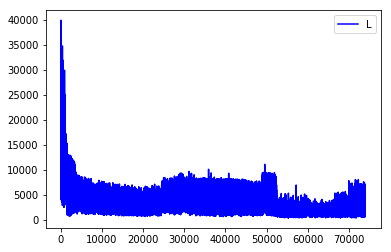

In [67]:
pyplot.plot(loss, 'b')
pyplot.legend(('Loss'), loc='upper right')

<class 'numpy.ndarray'> (1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)


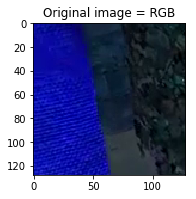

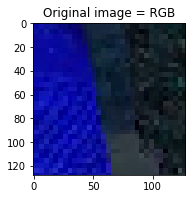

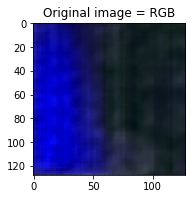

In [89]:

workspace.RunNet(train_model.Proto().name)
genImg = workspace.FetchBlob('convDoutNHWC')
print(type(genImg),genImg.shape)
noisyImage = workspace.FetchBlob('noisyImg')
refImage = workspace.FetchBlob('refImg')
print(genImg.shape)
print(noisyImage.shape)
print(refImage.shape)

tempImage = genImg.copy()
tempImage[tempImage < 0] = 0

showImage(refImage[0])
showImage(noisyImage[0])
showImage(tempImage[0])